# 1. IMPORTS

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler


# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE

# Bagging
from sklearn.neighbors import KNeighborsClassifier

# Naive bayes
from sklearn.naive_bayes import GaussianNB

# Library imports
import pandas as pd
import numpy as np
import warnings

# Modelling
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.stats import loguniform
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV

# 2. LOAD DATASET

In [2]:
#LOADING DATASETS
missing_values = ["N/A","na","?","", "NaN", "not reported"]

# LUSC dataset
lusc_data = pd.read_csv("C:\\Users\\sakma\\Desktop\\Ders Kayıtları\\Data Mining\\Final Project\\TCGA-LUSC_clinical.csv",na_values=missing_values)


#High 10 mutated genes for LUAD and LUSC
high_10_lusc = pd.read_csv(
    "C:\\Users\\sakma\\Desktop\\Ders Kayıtları\\Data Mining\\Final Project\\LUSC_10_high_gene.csv")

#Change the Patient column name with 'submitter_id' to merge dataframes
high_10_lusc = high_10_lusc.rename(columns={"Patient":"submitter_id"})
#For the genes which have NaN values we'll replace them with 0s.
high_10_lusc.fillna(0,inplace=True)

# #Merge dataframes with Luad and Lusc dataframe
lusc_data = pd.merge(lusc_data, high_10_lusc, on='submitter_id')

# Show luad_data
lusc_data.head()

,submitter_id,classification_of_tumor,last_known_disease_status,updated_datetime,primary_diagnosis,tumor_stage,age_at_diagnosis,vital_status,morphology,days_to_death,...,CDKN2A,CSMD3,FAT1,KEAP1,KMT2C,KMT2D,NF1,NFE2L2,PIK3CA,TP53
0,TCGA-18-3406,NaN,NaN,2018-09-06T16:31:22.449726-05:00,"Squamous cell carcinoma, NOS",stage ia,24477.0,dead,8070/3,371.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,TCGA-18-3407,NaN,NaN,2018-09-06T16:31:22.449726-05:00,"Squamous cell carcinoma, NOS",stage ib,26615.0,dead,8070/3,136.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,TCGA-18-3408,NaN,NaN,2018-09-06T16:31:22.449726-05:00,"Squamous cell carcinoma, NOS",stage ib,28171.0,dead,8070/3,2304.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,TCGA-18-3409,NaN,NaN,2018-09-06T16:31:22.449726-05:00,Basaloid squamous cell carcinoma,stage ia,27154.0,alive,8083/3,NaN,...,1.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,TCGA-18-3410,NaN,NaN,2018-09-06T16:31:22.449726-05:00,"Squamous cell carcinoma, NOS",stage iib,29827.0,dead,8070/3,146.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


# 3. PREPROCESSING

Before dropping fully nan cols (477, 52)
************************
submitter_id                           0.000000
classification_of_tumor              100.000000
last_known_disease_status            100.000000
updated_datetime                       0.000000
primary_diagnosis                      0.000000
tumor_stage                            0.000000
age_at_diagnosis                       1.257862
vital_status                           0.000000
morphology                             0.000000
days_to_death                         57.023061
days_to_last_known_disease_status    100.000000
created_datetime                     100.000000
state                                  0.000000
days_to_recurrence                   100.000000
diagnosis_id                           0.000000
tumor_grade                          100.000000
tissue_or_organ_of_origin              0.000000
days_to_birth                          1.257862
progression_or_recurrence            100.000000
prior_malignancy      

<ipython-input-3-fa70fbee1b77>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lusc_data['days_to_death'][i] = lusc_data['days_to_last_follow_up'][i]


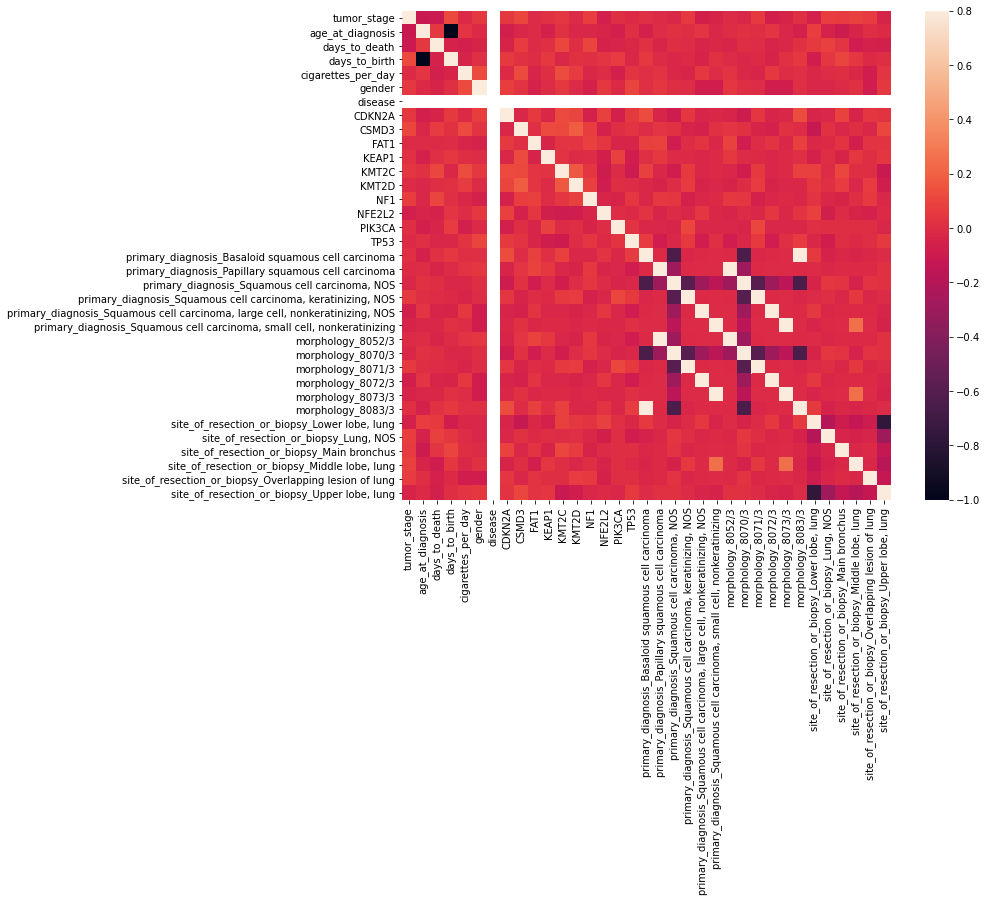

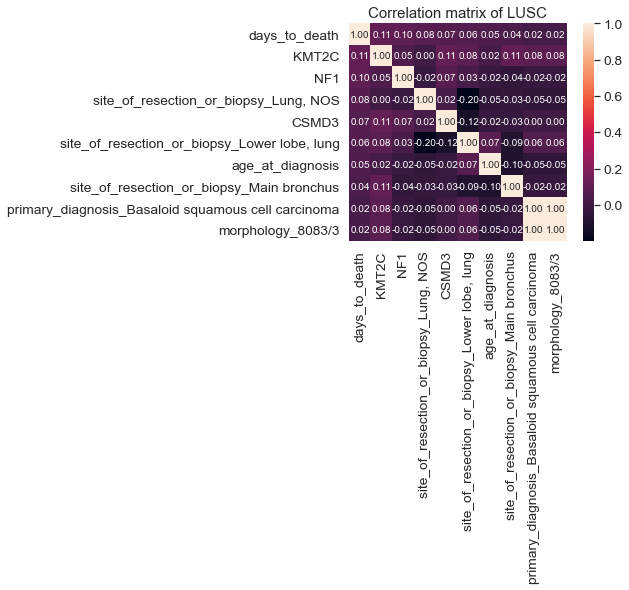

In [3]:
#Function for find an index of an item in dataFrame.
def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

       
#We can see the percentages of NaN values for each feature 
print("Before dropping fully nan cols", lusc_data.shape)
print("************************")
total_num_of_values = lusc_data.shape[0]
features_before_cleaning = lusc_data.shape[1]
print(((lusc_data.isnull().sum()) / total_num_of_values) * 100)
print("************************ \n\n")

#In days_to_death column values are NaN for 'alive' patient and there is just information about 'dead' patients how long they lived.
#If there is a case like that if patient vital status is dead but days_to_death is 0. We'll drop that index.
indexes = getIndexes(lusc_data, 0)
for i, j in indexes:
    if (j == 'days_to_death' and lusc_data["vital_status"][i] == 'dead'):
        lusc_data.drop([i], inplace=True)
lusc_data.reset_index(drop=True, inplace=True)

 # Now we'll fill the NaN values in days_to_death column with the days_to_last_follow_up
for i in range(lusc_data.shape[0]):
    if(lusc_data['vital_status'][i] == 'alive'):
        lusc_data['days_to_death'][i] = lusc_data['days_to_last_follow_up'][i]



# If there is a column which has more than %99 percentage(fully nan) null we'll drop it.
lusc_data = lusc_data.loc[:, lusc_data.isnull().mean() < .99]
lusc_data = lusc_data.loc[:, lusc_data.isnull().mean() < .19]

print(lusc_data.head())

'''We can drop year_of_birth column because we already have days_to_birth which is more suitable for our algorithm'''
lusc_data.drop("year_of_birth", axis=1, inplace=True)


'''In 'state' column all the variables are same for all rows as 'released'. We'll drop it'''
lusc_data.drop(["state"], axis=1, inplace=True)

'''Drop updated_datetime because there is no special information about patient status'''
lusc_data.drop(["updated_datetime"], axis=1, inplace=True)

#Reset the indexes after drop some index
lusc_data.reset_index(drop=True, inplace=True)
numeric_columns = {"age_at_diagnosis", "days_to_birth","cigarettes_per_day"}    

for col in numeric_columns:
        lusc_data[col] =  lusc_data[col].fillna(lusc_data[col].mean())


#At the end we should remove the ids. Because there is nothing special for these ids. These are just random variables.
# id_columns = {"diagnosis_id", "exposure_id", "demographic_id", "treatment_id", "bcr_patient_barcode",
#               "days_to_last_follow_up"}

id_columns = {"diagnosis_id", "exposure_id", "demographic_id", "treatment_id", "bcr_patient_barcode"}

lusc_data.drop(id_columns, axis=1, inplace=True)


'''It seems that tissue_or_organ_of_origin and site_of_resection_or_biopsy are identical features. We will make sure and if they
are identical we'll drop one of them'''
if(lusc_data['tissue_or_organ_of_origin'].equals(lusc_data['site_of_resection_or_biopsy'])):
    lusc_data.drop(["tissue_or_organ_of_origin"], axis=1, inplace=True)

#There are still some NaN values in 'tumor_stage' and 'days_to_death'. We'll drop them
lusc_data.dropna(axis=0, subset=['tumor_stage'], inplace = True)
lusc_data.dropna(axis=0, subset=['days_to_death'], inplace = True)


                                    ####### ENCODING ###########
# We should convert String values into integer values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# for col in data.columns:
#     print(col)

print("Gender counts before " )
print(lusc_data.gender.value_counts())
#Our binary columns are: ("vital_status","gender","disease")
binary_cols = ("vital_status","gender","disease")
for i in binary_cols:
    column = lusc_data.iloc[:, lusc_data.columns.get_loc(i):lusc_data.columns.get_loc(i) + 1].values
    lusc_data.iloc[:, lusc_data.columns.get_loc(i):lusc_data.columns.get_loc(i) + 1] = le.fit_transform(column[:,0])
print("Gender counts after " )
print(lusc_data.gender.value_counts())

#tumor_stage is an ordinal column. We'll encode it manuelly.    
tumor_stage_map = {'stage i': 1, 'stage ia': 1, 'stage ib': 1, 'stage ii': 2,
                'stage iia': 2, 'stage iib': 2, 'stage iii':3, 'stage iiia':3, 'stage iiib':3, 'stage iv':4 }

lusc_data['tumor_stage'] = lusc_data['tumor_stage'].map(tumor_stage_map)

categorical_columns = ("primary_diagnosis", "morphology",
                            "site_of_resection_or_biopsy")

# We'll apply OneHotEncoding for nominal_cols with get_dummies. First encode str values into numeric values
for col in categorical_columns:
    lusc_data = pd.concat([lusc_data, pd.get_dummies(lusc_data[col], prefix=col)], axis=1)
    lusc_data.drop([col], axis=1, inplace=True)

#Drop vital_status(alive or dead). In real life we don't need this feature.
lusc_data.drop(["vital_status"], axis=1, inplace=True) 


## DAYS_TO_DEATH ##
#If the patient remaining life more than 5 years we assumed the patient will live long, otherwise short. 0 High Risk, 1 Low Risk
lusc_data["days_to_death"] = (lusc_data["days_to_death"] > 1825).astype(int)    

corrmat = lusc_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'days_to_death')['days_to_death'].index
cm = np.corrcoef(lusc_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.title("Correlation matrix of "+"LUSC")
plt.show()





# 4. MODELLING

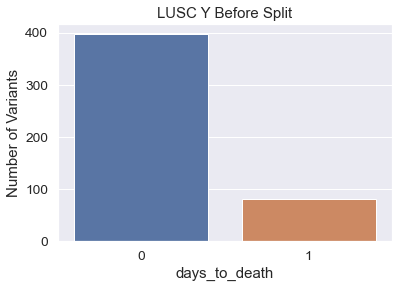

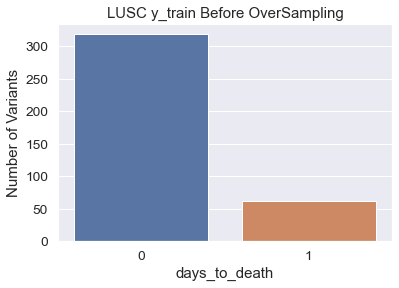

 X_train before sampling: (381, 34) (381,)
Class=1, n=319 (50.000%)
Class=0, n=319 (50.000%)
 X_train after OverSampling: (638, 34) (638,) 




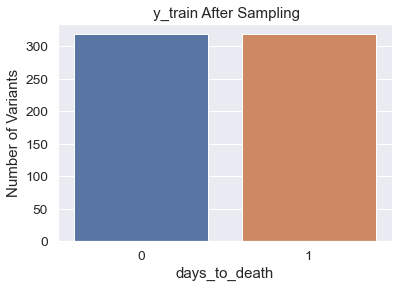

In [4]:
y = lusc_data.days_to_death
X = lusc_data.drop(["days_to_death","submitter_id"], axis=1, inplace=False)

y_train_raw = y.to_frame()
ax = sns.countplot(x="days_to_death", data=y_train_raw)
ax.set(xlabel='days_to_death', ylabel='Number of Variants')
plt.title("LUSC Y Before Split")
plt.show()

#Train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#y_train before UnderSample
y_train_raw = y_train.to_frame()
ax = sns.countplot(x="days_to_death", data=y_train_raw)
ax.set(xlabel='days_to_death', ylabel='Number of Variants')
plt.title("LUSC y_train Before OverSampling")
plt.show()
print(" X_train before sampling:", X_train.shape, y_train.shape)
# ros = RandomUnderSampler(random_state=0, sampling_strategy=1)
# X_train, y_train = ros.fit_resample(X_train, y_train)
###SMOTE FOR THE MULTICLASS PREDICTION
# transform the dataset
oversample = SMOTE(k_neighbors=4)
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))


print(" X_train after OverSampling:", X_train.shape, y_train.shape, "\n\n")
y_train_raw = y_train.to_frame()
ax = sns.countplot(x="days_to_death", data=y_train_raw)
ax.set(xlabel='days_to_death', ylabel='Number of Variants')
plt.title(" y_train After Sampling")
plt.show()




## Import Dependencies

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import NotFittedError

In [6]:
pipelines = {
    "LogisticRegression":make_pipeline(LogisticRegression(solver='liblinear')),
    "RandomForest":make_pipeline(RandomForestClassifier()),
    "GaussianNb":make_pipeline(GaussianNB()),
    "SVC":make_pipeline(SVC(probability=(True))),
    "KNN":make_pipeline(KNeighborsClassifier(n_neighbors=15, leaf_size = 30))
    
}

In [7]:
hypergrid = {
    'LogisticRegression':{
        'logisticregression__solver':['lbfgs', 'liblinear'],
        'logisticregression__C': [100, 10, 1.0, 0.1, 0.01, 0.001],
    },
    
    "RandomForest":{
        'randomforestclassifier__n_estimators':[25,50,75,150,200],
        'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
        'randomforestclassifier__max_depth' : [3,5,7,9],
        'randomforestclassifier__min_samples_leaf': [3,5,7,9]
    },
    
    "GaussianNb":{
        'gaussiannb__var_smoothing': np.logspace(0,-9, num=100)
        
    },
    
    "SVC":{
        'svc__C':[100, 10, 1.0, 0.1, 0.01, 0.001],
        'svc__gamma': [100, 10, 1.0, 0.1, 0.01, 0.001]
        
        
    },
    
    "KNN":{
        'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11]
    }
    
}

In [8]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hypergrid[algo], cv=10, n_jobs=-1)
    try:
        print("Starting training for {} has been successfully started".format(algo))
        model.fit(X_train, y_train)
        fit_models[algo] = model
        print("{} has been successfully fit".format(algo))
    except NotFittedError as e:
        print(repr(e))

Starting training for LogisticRegression has been successfully started
LogisticRegression has been successfully fit
Starting training for RandomForest has been successfully started
RandomForest has been successfully fit
Starting training for GaussianNb has been successfully started
GaussianNb has been successfully fit
Starting training for SVC has been successfully started
SVC has been successfully fit
Starting training for KNN has been successfully started
KNN has been successfully fit


In [9]:
fit_models['LogisticRegression'].predict(X_test)

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0])

# 5. EVALUATION

1. y_pred shape: (156,)


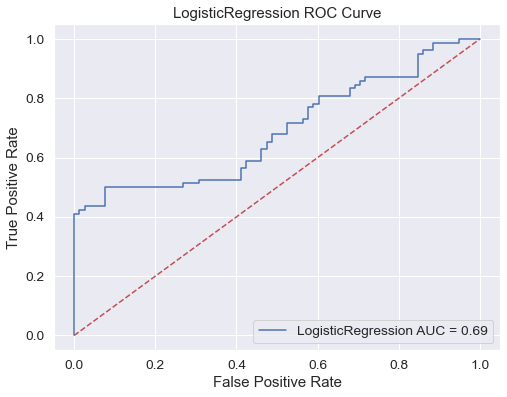

Accuracy score: Accuracy: % 68.58974358974359
Classification Report : for: LogisticRegression 
               precision    recall  f1-score   support

           0       0.64      0.87      0.74        78
           1       0.80      0.50      0.61        78

    accuracy                           0.69       156
   macro avg       0.72      0.69      0.67       156
weighted avg       0.72      0.69      0.67       156

1. y_pred shape: (156,)


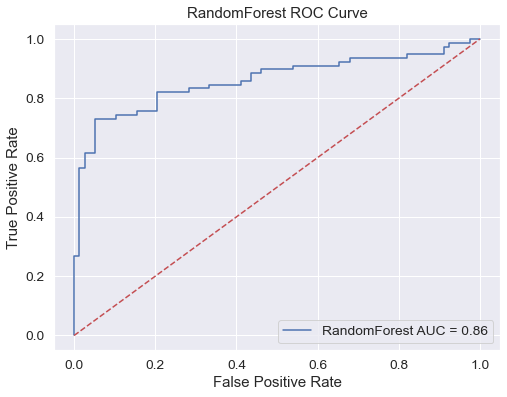

Accuracy score: Accuracy: % 78.84615384615384
Classification Report : for: RandomForest 
               precision    recall  f1-score   support

           0       0.72      0.95      0.82        78
           1       0.92      0.63      0.75        78

    accuracy                           0.79       156
   macro avg       0.82      0.79      0.78       156
weighted avg       0.82      0.79      0.78       156

1. y_pred shape: (156,)


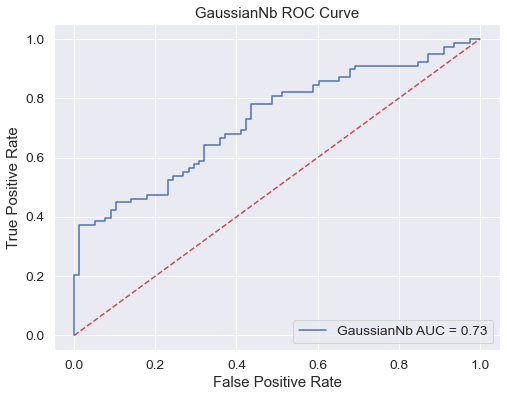

Accuracy score: Accuracy: % 62.17948717948718
Classification Report : for: GaussianNb 
               precision    recall  f1-score   support

           0       0.71      0.41      0.52        78
           1       0.59      0.83      0.69        78

    accuracy                           0.62       156
   macro avg       0.65      0.62      0.60       156
weighted avg       0.65      0.62      0.60       156

1. y_pred shape: (156,)


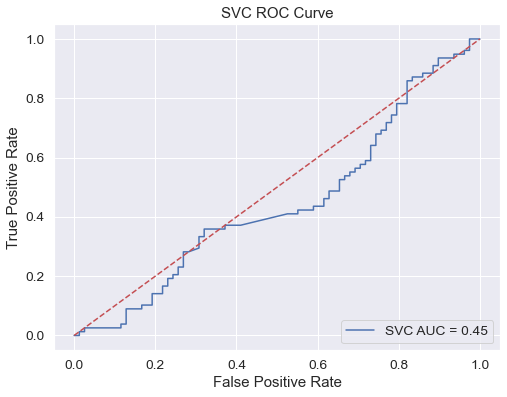

Accuracy score: Accuracy: % 49.358974358974365
Classification Report : for: SVC 
               precision    recall  f1-score   support

           0       0.50      0.69      0.58        78
           1       0.49      0.29      0.37        78

    accuracy                           0.49       156
   macro avg       0.49      0.49      0.47       156
weighted avg       0.49      0.49      0.47       156

1. y_pred shape: (156,)


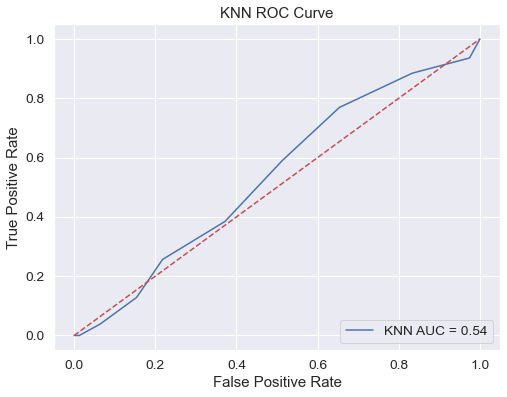

Accuracy score: Accuracy: % 50.641025641025635
Classification Report : for: KNN 
               precision    recall  f1-score   support

           0       0.51      0.63      0.56        78
           1       0.51      0.38      0.44        78

    accuracy                           0.51       156
   macro avg       0.51      0.51      0.50       156
weighted avg       0.51      0.51      0.50       156



In [10]:
#We'll keep AUC scores as dictionary
auc_scores = {}

for algo, model in fit_models.items():
    
    y_preds = model.predict_proba(X_test)
    preds = y_preds[:, 1]  # pred probability
    predict = model.predict(X_test)
    print("1. y_pred shape:", predict.shape)
    fpr, tpr, _ = roc_curve(y_test, preds)

    auc_score = auc(fpr, tpr)
    auc_scores[algo] = auc_score
    plt.subplots(figsize=(8, 6))
    plt.title(algo + ' ROC Curve')
    plt.plot(fpr, tpr, label='{} AUC = {:.2f}'.format(algo, auc_score))
    plt.plot([0, 1], [0, 1], 'r--')

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.legend(loc='lower right')
    plt.show()

    print("{} Accuracy: %".format("Accuracy score:"), accuracy_score(y_test, predict) * 100)
    print("Classification Report : for:", algo, "\n", classification_report(y_test, predict))


### Best Model
Random Forest is the best model for the LUSC dataset with 0.86 AUC score.

In [11]:
best_model = fit_models['RandomForest']

# 6. DEPLOY MODEL

* URLS
    - Dallas: https://us-south.ml.cloud.ibm.com,
    - London - https://eu-gb.ml.cloud.ibm.com,
    - Frankfurt - https://eu-de.ml.cloud.ibm.com,
    - Tokyo - https://jp-tok.ml.cloud.ibm.com

## 6.1 Import and Install dependencies

In [12]:
!pip install -U ibm-watson-machine-learning

You should consider upgrading via the 'c:\anaconda3\python.exe -m pip install --upgrade pip' command.


In [13]:
from ibm_watson_machine_learning import APIClient
import json
import numpy as np

## 6.2 Authenticate and Set Space

In [14]:
wml_credentials = {
    "apikey":"lcAbuQgUeTMXpPaNr1XDNlh-p4UqwbX91ccCJIJimLSL",
    "url":"https://eu-de.ml.cloud.ibm.com"
}

In [15]:
wml_client = APIClient(wml_credentials)
wml_client.spaces.list()

Python 3.7 and 3.8 frameworks are deprecated and will be removed in a future release. Use Python 3.9 framework instead.
Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ----  ------------------------
ID                                    NAME  CREATED
a342e7cc-2978-482c-9e39-e9434912506b  PROD  2022-04-27T15:01:58.426Z
------------------------------------  ----  ------------------------


In [16]:
SPACE_ID="a342e7cc-2978-482c-9e39-e9434912506b"

In [17]:
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

## 6.3 Save and Deploy Model

In [18]:
MODEL_NAME = 'LUSC Clinical-Genetic Model'
DEPLOYMENT_NAME = 'LUSC Clinical-Genetic Model Deployment'
BEST_MODEL = best_model

In [19]:
# Set Python Version
software_spec_uid = wml_client.software_specifications.get_id_by_name("runtime-22.1-py3.9")
software_spec_uid

# Setup model meta
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0', 
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}


                                                                      
#Save model
model_details = wml_client.repository.store_model(
    pipeline = pipelines["RandomForest"],
    meta_props=model_props, 
    model=BEST_MODEL, 
    training_data=X_train, 
    training_target=y_train
    
)

In [20]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'days_to_death',
  'software_spec': {'id': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
   'name': 'runtime-22.1-py3.9'},
  'training_data_references': [{'connection': {'access_key_id': 'not_applicable',
     'endpoint_url': 'not_applicable',
     'secret_access_key': 'not_applicable'},
    'id': '1',
    'location': {},
    'schema': {'fields': [{'name': 'tumor_stage', 'type': 'int64'},
      {'name': 'age_at_diagnosis', 'type': 'float64'},
      {'name': 'days_to_birth', 'type': 'float64'},
      {'name': 'cigarettes_per_day', 'type': 'float64'},
      {'name': 'gender', 'type': 'int32'},
      {'name': 'disease', 'type': 'int32'},
      {'name': 'CDKN2A', 'type': 'float64'},
      {'name': 'CSMD3', 'type': 'float64'},
      {'name': 'FAT1', 'type': 'float64'},
      {'name': 'KEAP1', 'type': 'float64'},
      {'name': 'KMT2C', 'type': 'float64'},
      {'name': 'KMT2D', 'type': 'float64'},
      {'name': 'NF1', 'type': '

In [21]:
model_uid = wml_client.repository.get_model_id(model_details); model_uid

'1412be29-150c-4711-aab7-461486753c27'

In [22]:
# Set meta
deployment_props = {
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME, 
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

# Deploy
deployment = wml_client.deployments.create(
    artifact_uid=model_uid, 
    meta_props=deployment_props 
)

# Output result
deployment



#######################################################################################

Synchronous deployment creation for uid: '1412be29-150c-4711-aab7-461486753c27' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='69abe067-36a8-4af3-aed3-1f5f38010628'
------------------------------------------------------------------------------------------------




{'entity': {'asset': {'id': '1412be29-150c-4711-aab7-461486753c27'},
  'custom': {},
  'deployed_asset_type': 'model',
  'hardware_spec': {'id': 'e7ed1d6c-2e89-42d7-aed5-863b972c1d2b',
   'name': 'S',
   'num_nodes': 1},
  'name': 'LUSC Clinical-Genetic Model Deployment',
  'online': {},
  'space_id': 'a342e7cc-2978-482c-9e39-e9434912506b',
  'status': {'online_url': {'url': 'https://eu-de.ml.cloud.ibm.com/ml/v4/deployments/69abe067-36a8-4af3-aed3-1f5f38010628/predictions'},
   'serving_urls': ['https://eu-de.ml.cloud.ibm.com/ml/v4/deployments/69abe067-36a8-4af3-aed3-1f5f38010628/predictions'],
   'state': 'ready'}},
 'metadata': {'created_at': '2022-05-08T11:56:06.793Z',
  'id': '69abe067-36a8-4af3-aed3-1f5f38010628',
  'modified_at': '2022-05-08T11:56:06.793Z',
  'name': 'LUSC Clinical-Genetic Model Deployment',
  'owner': 'IBMid-66600225I3',
  'space_id': 'a342e7cc-2978-482c-9e39-e9434912506b'},
 'system': {'warnings': [{'id': 'Deprecated',
    'message': 'online_url is deprecated a

## 6.4 Score Against Deployed Model

In [23]:
deployment_uid = wml_client.deployments.get_uid(deployment)
payload = {
    "input_data":[{
        "fields":X_test.columns.to_numpy().tolist(),
         "values":X_test.to_numpy().tolist()
    }]
}
result = wml_client.deployments.score(deployment_uid, payload)
result

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [[0, [0.7379801053978692, 0.2620198946021308]],
    [0, [0.8230247073730048, 0.17697529262699543]],
    [0, [0.7241271557112539, 0.2758728442887459]],
    [0, [0.7043031469574714, 0.2956968530425284]],
    [0, [0.6398076091797968, 0.360192390820203]],
    [0, [0.6282405837013697, 0.37175941629863035]],
    [0, [0.6464772442934784, 0.35352275570652175]],
    [0, [0.8339981766052286, 0.16600182339477165]],
    [0, [0.7093768662546506, 0.2906231337453496]],
    [0, [0.6205376308689488, 0.3794623691310511]],
    [0, [0.8278623695900786, 0.1721376304099213]],
    [0, [0.708095864877299, 0.29190413512270036]],
    [0, [0.6012074378238637, 0.3987925621761365]],
    [1, [0.2592572146262281, 0.7407427853737718]],
    [0, [0.7606529442866687, 0.239347055713331]],
    [0, [0.7793304178920689, 0.22066958210793122]],
    [0, [0.5397045340205509, 0.46029546597944887]],
    [0, [0.5690272821818269, 0.43097271781817315]],
    [0, 

In [27]:
#We need to get the every first element of above 2D array
# [i[0] for i in result['predictions'][0]['values']]

pred_values = np.squeeze([i[0] for i in result['predictions'][0]['values']]); pred_values
preddf = X_test.join(y_test)
preddf['Scores'] = pred_values
preddf.tail()

,tumor_stage,age_at_diagnosis,days_to_birth,cigarettes_per_day,gender,disease,CDKN2A,CSMD3,FAT1,KEAP1,...,morphology_8073/3,morphology_8083/3,"site_of_resection_or_biopsy_Lower lobe, lung","site_of_resection_or_biopsy_Lung, NOS",site_of_resection_or_biopsy_Main bronchus,"site_of_resection_or_biopsy_Middle lobe, lung",site_of_resection_or_biopsy_Overlapping lesion of lung,"site_of_resection_or_biopsy_Upper lobe, lung",days_to_death,Scores
151,2,27189.090389,-27189.090389,2.552215,1,0,0.000000,0.214650,0.0,0.0,...,0,0,1,0,0,0,0,0,1,1
152,2,23500.048449,-23500.048449,1.498317,0,0,0.367215,1.367215,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
153,1,23462.531136,-23462.531136,1.988027,1,0,0.256298,1.256298,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
154,2,27479.338135,-27479.338135,2.898493,1,0,0.000000,0.157958,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
155,2,27169.133704,-27169.133704,2.608038,1,0,0.000000,0.353238,0.0,0.0,...,0,0,1,0,0,0,0,0,1,1


In [28]:
X_test.columns.to_numpy().tolist()

['tumor_stage',
 'age_at_diagnosis',
 'days_to_birth',
 'cigarettes_per_day',
 'gender',
 'disease',
 'CDKN2A',
 'CSMD3',
 'FAT1',
 'KEAP1',
 'KMT2C',
 'KMT2D',
 'NF1',
 'NFE2L2',
 'PIK3CA',
 'TP53',
 'primary_diagnosis_Basaloid squamous cell carcinoma',
 'primary_diagnosis_Papillary squamous cell carcinoma',
 'primary_diagnosis_Squamous cell carcinoma, NOS',
 'primary_diagnosis_Squamous cell carcinoma, keratinizing, NOS',
 'primary_diagnosis_Squamous cell carcinoma, large cell, nonkeratinizing, NOS',
 'primary_diagnosis_Squamous cell carcinoma, small cell, nonkeratinizing',
 'morphology_8052/3',
 'morphology_8070/3',
 'morphology_8071/3',
 'morphology_8072/3',
 'morphology_8073/3',
 'morphology_8083/3',
 'site_of_resection_or_biopsy_Lower lobe, lung',
 'site_of_resection_or_biopsy_Lung, NOS',
 'site_of_resection_or_biopsy_Main bronchus',
 'site_of_resection_or_biopsy_Middle lobe, lung',
 'site_of_resection_or_biopsy_Overlapping lesion of lung',
 'site_of_resection_or_biopsy_Upper lobe

In [29]:
X_test.iloc[0].to_numpy().tolist()

[1.0,
 27076.0,
 -27076.0,
 2.868554558337272,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]